# Regression

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

### Goals

In the previous notebook we used simple regression to quantify the relationship between two variables.

In this notebook we'll get farther into regression, including multiple regression and one of my all-time favorite tools, logistic regression.

These tools will allow us to explore relationships among sets of variables.  As an example, we will use data from the GSS to explore the relationship between income, education, age, and sex.

But first let's understand the limits of single regression.

In [10]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

## Limits of single regression

In a previous exercise, you made a scatter plot of vegetable consumption as a function of income, and plotted a line of best fit.

Here's what it looks like:

![](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/fig08-01.png)

The slope of the line is 0.07, which means that the difference between the lowest and highest income brackets is about 0.49 servings per day.

So that's not a very big difference.

But it was an arbitrary choice to plot vegetables as a function of income.  We could have plotted it the other way around, like this.

![](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/fig08-02.png)

The slope of this line is about 0.2, which means that the difference between 0 and 10 servings per day is about 2 income levels, roughly from level 5 to level 7.

And the difference between income levels 5 and 7 is about $30,000 per year, which is substantial.

So if we use vegetable consumption to predict income, we see a big difference.  But when we used income to predict vegetable consumption, we saw a small difference.

This example shows that regression is not symmetric; the regression of A onto B is not the same as the regression of B onto A.

We can see that more clearly by putting the two figures side by side and plotting both regression lines on both figures.

![](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/fig08-03.png)

They are different because they are based on different assumptions.  

* On the left, we treat income as a known quantity and vegetable consumption as random.

* On the right, vegetable consumption is known and income is random.

When you run a regression model, you make decisions about how to treat the data, and those decisions affect the results you get.

This example is meant to demonstrate another point, which is that regression doesn't tell you much about causation.

If you think people with lower income can't afford vegetables, you might look at the figure on the left and conclude that it doesn't make much difference.

If you think better diet increases income, the figure on the right might make you think it does.

But in general, regression can't tell you what causes what.  If you see a relationship between any two variables, A and B, the reason for the relationship might be that A causes B, B causes A, or there might be other factors that cause both A and B.

Regression alone can't tell you which way it goes.

However, we have tools for teasing apart relationships among multiple variables; one of the most important is multiple regression.

SciPy doesn't do multiple regression, so we'll to switch to a new library, StatsModels.  Here's the import statement.

In [17]:
import statsmodels.formula.api as smf

For the first example, we'll load data from the Behavioral Risk Factor Surveillance Survey (BRFSS), which we saw in the previous notebook.

In [18]:
# Get the data file

import os

if not os.path.exists('brfss.hdf5'):
    !wget https://github.com/AllenDowney/ElementsOfDataScience/raw/master/brfss.hdf5

In [20]:
import pandas as pd

brfss = pd.read_hdf('brfss.hdf5', 'brfss')

Now we can use StatsModels to fit a regression mode.  The name of the function is `ols`, which stands for "ordinary least squares", another name for regression.

In [21]:
results = smf.ols('INCOME2 ~ _VEGESU1', data=brfss).fit()

The first argument is a formula string that specifies that we want to regress income as a function of vegetable consumption.

The second argument is the BRFSS DataFrame.  The names in the formula correspond to columns in the DataFrame.

The result from `ols()` represents the model; then we run `fit()` to get the results.

In [22]:
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

Results is a `RegressionResultsWrapper`, which contains a lot of information, but the first thing we'll look at is the attribute `params`, which contains the estimated intercept and the slope associated with `_VEGESU1`.

In [23]:
results.params

Intercept    5.450700
_VEGESU1     0.204935
dtype: float64

And we get the same results we got from SciPy, so that's good!

In the next section we'll move on to multiple regression.  But first, some exercises.

**Exercise:** In the BRFSS dataset, there is a strong relationship between vegetable consumption and income. The income of people who eat 8 servings of vegetables per day is double the income of people who eat none, on average.

Which of the following conclusions can we draw from this data?

A.  Eating a good diet leads to better health and higher income.

B.  People with higher income can afford a better diet.

C.  People with high income are more likely to be vegetarians.

In [24]:
# You cannot make any of the following conclusions, no way to know casuations. Also more vegtables does not mean vegetarian.

**Exercise:** Let's run a regression using SciPy and StatsModels, and confirm we get the same results.

- Compute the regression of `_VEGESU1` as a function of `INCOME2` using SciPy's `linregress()`.

- Compute the regression of `_VEGESU1` as a function of `INCOME2` using StatsModels' `smf.ols()`.

In [25]:
import scipy as sp
data = brfss.dropna(subset=['INCOME2', '_VEGESU1'])
inc_clean = data['INCOME2']
veg_clean = data['_VEGESU1']
sp.stats.linregress(inc_clean, veg_clean)

LinregressResult(slope=0.0698804809210135, intercept=1.5287786243365251, rvalue=0.11967005884859927, pvalue=1.378503916775768e-238, stderr=0.0021109763563319714)

In [26]:
smf.ols('_VEGESU1 ~ INCOME2', data=data).fit().params

Intercept    1.528779
INCOME2      0.069880
dtype: float64

## Multiple regression

Now that we have StatsModels, getting from single to multiple regression is easy.

As an example, we'll use data from the General Social Survey, which we saw in Notebook 7, and we'll explore variables that are related to income.

First, let's load the GSS data.

In [27]:
# Get the data file

import os

if not os.path.exists('gss.hdf5'):
    !wget https://github.com/AllenDowney/ElementsOfDataScience/raw/master/gss.hdf5

--2020-03-02 13:52:36--  https://github.com/AllenDowney/ElementsOfDataScience/raw/master/gss.hdf5
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/gss.hdf5 [following]
--2020-03-02 13:52:37--  https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/gss.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5506296 (5.3M) [application/octet-stream]
Saving to: ‘gss.hdf5’

gss.hdf5            100%[===================>]   5.25M  13.3MB/s    in 0.4s    

2020-03-02 13:52:37 (13.3 MB/s) - 

In [28]:
import pandas as pd

gss = pd.read_hdf('gss.hdf5', 'gss')

Then we run a regression of real income as a function of years of education.  The first argument of `ols()` is a formula that specifies the variables in the regression:

In [29]:
results = smf.ols('realinc ~ educ', data=gss).fit()
results.params

Intercept   -11539.147837
educ          3586.523659
dtype: float64

On the left, "real income" is the variable we are trying to predict; on the right, "education" is the variable we are using to inform the predictions.

And here are the results.  The estimated slope is almost 3600, which means that each additional year of education is associated with an additional $3600 of income.

But income also depends on age, so it would be good to include that in the model, too.

Here's how: 

In [30]:
results = smf.ols('realinc ~ educ + age', data=gss).fit()
results.params

Intercept   -16117.275684
educ          3655.166921
age             83.731804
dtype: float64

On the right side of the formula, you can list as many variables as you like, in this case, education and age.

The `plus` sign indicates that we expect the contributions of the two variables to be additive, which is a common assumption for models like this.

The estimated slope for education is a little higher than what we saw before, about $3650 per year.

The estimated slope for `age` is only about $80 per year, which is surprisingly small.

To see what's going on, let's look more closely at the relationship between income and age.

## Groupby

I'll use `groupby()`, which is a Pandas feature we have not seen before, to divide the DataFrame into age groups.  The result is a `GroupBy` object that contains one group for each value of `age`.

In [31]:
grouped = gss.groupby('age')
type(grouped)

pandas.core.groupby.generic.DataFrameGroupBy

The `GroupBy` object behaves like a DataFrame in many ways.  You can use brackets to select a column, like `realinc` in this example, and then invoke a method like `mean()`.

In [32]:
mean_income_by_age = grouped['realinc'].mean()

The result is a Pandas series that contains the mean income for each age group, which we can plot like this.

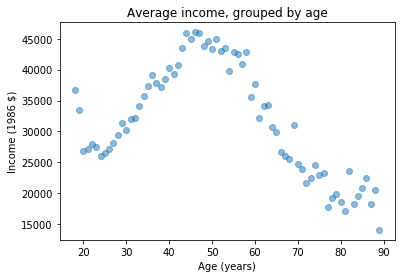

In [33]:
import matplotlib.pyplot as plt

plt.plot(mean_income_by_age, 'o', alpha=0.5)
plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.title('Average income, grouped by age');

Average income increases from age 20 to age 50, then starts to fall.  

And that explains why the estimated slope is so small, because the relationship is non-linear.  Remember that correlation and single regression can't measure non-linear relationships.  

But multiple regression can!  To describe a non-linear relationship, one option is to add a new variable that is a non-linear combination of other variables.

As an example, I'll create a new variable called `age2` that equals `age` squared.

In [34]:
gss['age2'] = gss['age']**2

Now we can run a regression with both `age` and `age2` on the right side.

In [35]:
model = smf.ols('realinc ~ educ + age + age2', data=gss)
results = model.fit()
results.params

Intercept   -48058.679679
educ          3442.447178
age           1748.232631
age2           -17.437552
dtype: float64

The slope associated with age is substantial, about $1700 per year.  

The slope associated with `age2` is about -$17, but that's harder to interpret.

In the next section, we'll see methods to interpret multivariate models and visualize the results.  But first, let's practice multiple regression.

**Exercise:** To get a closer look at the relationship between income and education, let's use the variable `educ` to group the data, then plot mean income in each group.

- Group `gss` by `educ`. Store the result in `grouped`.

- From `grouped`, extract `realinc` and compute the mean.

- Plot mean income in each education group as a scatter plot.

What can you say about the relationship between education and income?  Does it look like a linear relationship?

Text(0.5, 1.0, 'Average income, grouped by education')

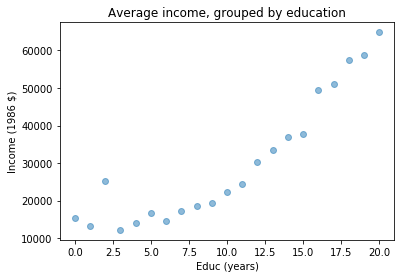

In [36]:
grouped = gss.groupby('educ')
mean_income_by_educ = grouped['realinc'].mean()

plt.plot(mean_income_by_educ, 'o', alpha=.5)
plt.xlabel('Educ (years)')
plt.ylabel('Income (1986 $)')
plt.title('Average income, grouped by education')

**Exercise:** The graph in the previous exercise suggests that the relationship between income and education is non-linear.  So let's try fitting a non-linear model.

- Add a column named `educ2` to the `gss` DataFrame; it should contain the values from `educ` squared.  

- Run a regression model that uses `educ`, `educ2`, `age`, and `age2` to predict `realinc`.


In [37]:
gss['educ2'] = gss['educ']**2
model = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss)
results = model.fit()
results.params

Intercept   -23241.884034
educ          -528.309369
educ2          159.966740
age           1696.717149
age2           -17.196984
dtype: float64

## Visualizing regression results

In the previous section we ran a multiple regression model to characterize the relationships between income, age, and education.

Because the model includes quadratic terms, the parameters are hard to interpret. For example, you might notice that the parameter for `educ` is negative, and that might be a surprise, because it suggests that higher education is associated with lower income.

But the parameter for `educ2` is positive, and that makes a big difference.  In this section we'll see a way to interpret the model visually and validate it against data.

Here's the model from the previous exercise.

In [38]:
gss['age2'] = gss['age']**2
gss['educ2'] = gss['educ']**2

model = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss)
results = model.fit()
results.params

Intercept   -23241.884034
educ          -528.309369
educ2          159.966740
age           1696.717149
age2           -17.196984
dtype: float64

Sometimes we can understand a model by looking at its parameters, but often it is better to look at its predictions.

The regression results provide a method called `predict()` that uses the model to generate predictions.

It takes a DataFrame as a parameter and returns a Series with a prediction for each row in the DataFrame.

To use it, I'll create a new DataFrame with `age` running from 18 to 89, and `age2` set to `age` squared.

In [39]:
import numpy as np

df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['age2'] = df['age']**2

Next, I'll pick a level for `educ`, like 12 years, which is the most common value.  When you assign a single value to a column in a DataFrame, Pandas makes a copy for each respondent.

In [40]:
df['educ'] = 12
df['educ2'] = df['educ']**2

Then we can use `results` to predict the average income for each age group, holding education constant.

In [41]:
pred12 = results.predict(df)

The result from `predict()` is a Series with one prediction for each row.  So we can plot it with age on the `x` axis and the predicted income for each age group on the `y` axis.

And we can plot the data for comparison.

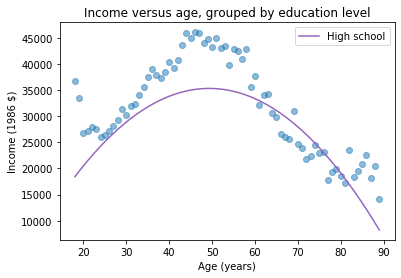

In [42]:
plt.plot(mean_income_by_age, 'o', alpha=0.5)

plt.plot(df['age'], pred12, label='High school', color='C4')

plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.title('Income versus age, grouped by education level')
plt.legend();

The blue dots show the average income in each age group.

The orange line shows the predictions generated by the model, holding education constant.

This plot shows the shape of the model, a downward-facing parabola.

We can do the same thing with other levels of education, like 14 years, which is the nominal time to each an Associate's degree, and 16 years, which is the nominal time to earn a Bachelor's degree.

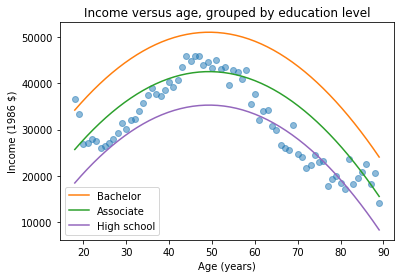

In [43]:
plt.plot(mean_income_by_age, 'o', alpha=0.5)

df['educ'] = 16
df['educ2'] = df['educ']**2
pred16 = results.predict(df)
plt.plot(df['age'], pred16, label='Bachelor')

df['educ'] = 14
df['educ2'] = df['educ']**2
pred14 = results.predict(df)
plt.plot(df['age'], pred14, label='Associate')

plt.plot(df['age'], pred12, label='High school', color='C4')

plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.title('Income versus age, grouped by education level')
plt.legend();

The lines show mean income, as predicted by the model, as a function of age, for three levels of education.

This visualization helps validate the model, since we can compare the predictions with the data.  And it helps us interpret the model since we can see the separate contributions of age and education.

In the exercises, you'll have a chance to run a multiple regression, generate predictions, and visualize the results.

**Exercise:** At this point, we have a model that predicts income using age, education, and sex.

Let's see what it predicts for different levels of education, holding `age` constant.

- Create an empty DataFrame named `df`.

- Using `np.linspace()`, add a variable named `educ` to `df` with a range of values from `0` to `20`.

- Add a variable named `age` with the constant value `30`.

- Use `df` to generate predicted income as a function of education.

In [44]:
df = pd.DataFrame()
df['educ'] = np.linspace(0, 20)
df['age'] = 30
df['age2'] = df['age']**2
df['educ2'] = df['educ']**2
pred = results.predict(df)

In [46]:
df

,educ,age,age2,educ2
0,0.000000,30,900,0.000000
1,0.408163,30,900,0.166597
2,0.816327,30,900,0.666389
3,1.224490,30,900,1.499375
4,1.632653,30,900,2.665556
5,2.040816,30,900,4.164931
6,2.448980,30,900,5.997501
7,2.857143,30,900,8.163265
8,3.265306,30,900,10.662224
9,3.673469,30,900,13.494377


In [45]:
pred

0     12182.344976
1     11993.358518
2     11857.672098
3     11775.285717
4     11746.199374
5     11770.413069
6     11847.926802
7     11978.740574
8     12162.854384
9     12400.268232
10    12690.982118
11    13034.996043
12    13432.310006
13    13882.924007
14    14386.838046
15    14944.052124
16    15554.566240
17    16218.380394
18    16935.494586
19    17705.908817
20    18529.623086
21    19406.637393
22    20336.951738
23    21320.566122
24    22357.480544
25    23447.695004
26    24591.209502
27    25788.024039
28    27038.138614
29    28341.553227
30    29698.267878
31    31108.282568
32    32571.597295
33    34088.212062
34    35658.126866
35    37281.341709
36    38957.856589
37    40687.671509
38    42470.786466
39    44307.201462
40    46196.916495
41    48139.931567
42    50136.246678
43    52185.861826
44    54288.777013
45    56444.992238
46    58654.507502
47    60917.322803
48    63233.438143
49    65602.853521
dtype: float64

**Exercise:** Now let's visualize the results from the previous exercise!

- Group the GSS data by `educ` and compute the mean income in each education group.

- Plot mean income for each education group as a scatter plot.

- Plot the predictions from the previous exercise.

How do the predictions compare with the data?

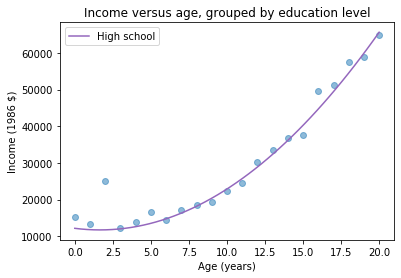

In [50]:
plt.plot(mean_income_by_educt, 'o', alpha=0.5)

plt.plot(df['educ'], pred, label='High school', color='C4')

plt.xlabel('Age (years)')
plt.ylabel('Income (1986 $)')
plt.title('Income versus age, grouped by education level')
plt.legend();

The predictions align very well with the data. With almost all the points on the line or right next to it.

**Optional Exercise:** Extend the previous exercise to include predictions for a few other age levels. 

## Logistic regression

At last we have come to one of my favorite topics, logistic regression.

To understand logistic regression, we have to start with categorical variables.

Most of the variables we have used so far --- like income, age, and education --- are numerical.

But variables like sex and race are categorical; that is, each respondent belongs to one of a specified set of categories.

With StatsModels, it is easy to include a categorical variable as part of a regression model.

Here's how.  In the formula string, the letter C indicates that `sex` is a categorical variable.

In [51]:
formula = 'realinc ~ educ + educ2 + age + age2 + C(sex)'
results = smf.ols(formula, data=gss).fit()
results.params

Intercept     -22369.453641
C(sex)[T.2]    -4156.113865
educ            -310.247419
educ2            150.514091
age             1703.047502
age2             -17.238711
dtype: float64

The regression treats the value `sex=1`, which is male, as the default, and reports the difference associated with the value `sex=2`, which is female.

So this result indicates that income for women is about $4100 less than for men, after controlling for age and education.

If a categorical variable has only two values, it's called a boolean variable.  For example, one of the questions in the General Social Survey asks "Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?"

The column is called `gunlaw`, and here are the values.  '1' means yes and `2` means no, so most respondents are in favor.

To explore the relationship between this variable and factors like age, sex, and education, we can use logistic regression.

StatsModels provides logistic regression, but to use it, we have to recode the variable so `1` means `yes` and 0 means no.  We can do that by replacing `2` with `0`.

In [52]:
gss['gunlaw'].value_counts()

1.0    30918
2.0     9632
Name: gunlaw, dtype: int64

In [ ]:
gss['gunlaw'].replace([2], [0], inplace=True)

The keyword argument `inplace=True` means that this function modifies the `gunlaw` column "in place"; that is, it modifies the column in the DataFrame rather than making a new Series.

And we can check the results.

In [54]:
gss['gunlaw'].value_counts()

1.0    30918
0.0     9632
Name: gunlaw, dtype: int64

Now we can run the regression.  Instead of `ols()`, we use `logit()`, which is named for the logit function, which is related to logistic regression.

In [1]:
formula = 'gunlaw ~ age + age2 + educ + educ2 + C(sex)'
results = smf.logit(formula, data=gss).fit()

NameError: name 'smf' is not defined

Estimating the parameters for the logistic model is an iterative process, so the output contains information about the number of iterations.

Other than that, everything is the same as what we have seen before.

And here are the results.  

In [56]:
results.params

Intercept      1.653862
C(sex)[T.2]    0.757249
age           -0.018849
age2           0.000189
educ          -0.124373
educ2          0.006653
dtype: float64

The parameters are in the form of "log odds", which you may or may not be familiar with.  I won't explain them in detail here, except to say that positive values are associated with things that make the outcome more likely; negative values make the outcome less likely.

For example, the parameter associated with `sex=2` is 0.75, which indicates that women are more likely to support this form of gun control.  To see how much more likely, we can generate and predict distributions, as we did with linear regression.

As an example, I'll generate predictions for different ages and sexes, with education held constant.

First we need a DataFrame with `age` and `educ`.

In [2]:
df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['educ'] = 12

NameError: name 'pd' is not defined

Then we can compute `age2` and `educ2`.

In [ ]:
df['age2'] = df['age']**2
df['educ2'] = df['educ']**2

We can generate predictions for men like this.

In [ ]:
df['sex'] = 1
pred1 = results.predict(df)

And for women like this.

In [ ]:
df['sex'] = 2
pred2 = results.predict(df)

Now, to visualize the results, I start by plotting the data.  As we've done before, we'll divide the respondents into age groups and compute the mean in each group.  The mean of a binary variable is the fraction of people in favor.

Then we can plot the predictions, for men and women, as a function of age.

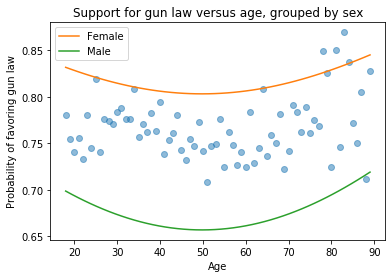

In [61]:
grouped = gss.groupby('age')
favor_by_age = grouped['gunlaw'].mean()
plt.plot(favor_by_age, 'o', alpha=0.5)

plt.plot(df['age'], pred2, label='Female')
plt.plot(df['age'], pred1, label='Male')

plt.xlabel('Age')
plt.ylabel('Probability of favoring gun law')
plt.title('Support for gun law versus age, grouped by sex')
plt.legend();

According to the model, people near age 50 are least likely to support gun control (at least as this questions was posed).

And women are more likely to support it than men, by almost 15 percentage points.

Logistic regression is a powerful tool for exploring relationships between a binary variable and the factors that predict it.

In the exercises, you'll explore the factors that predict support for legalizing marijuana.

**Exercise:** Let's use logistic regression to predict a binary variable.  Specifically, we'll use age, sex, and education level to predict support for legalizing cannabis (marijuana) in the U.S.

In the GSS dataset, the variable `grass` records the answer to the question "Do you think the use of marijuana should be made legal or not?"

1. First, use `replace` to recode the `grass` column so that `1` means yes and `0` means no.  Use `value_counts` to check.

2. Next, use `smf.logit()` to predict `grass` using the variables `age`, `age2`, `educ`, and `educ2`, along with `sex` as a categorical variable.  Display the parameters.  Are men or women more likely to support legalization?

3. To generate predictions, start with an empty DataFrame.  Add a column called `age` that contains a sequence of values from 18 to 89.  Add a column called `educ` and set it to 12 years.  Then compute a column, `age2`, which is the square of `age`, and a column, `educ2`, which is the square of `educ`. 

4. Use `predict` to generate predictions for men (`sex=1`) and women (`sex=2`).

5. Generate a plot that shows (1) the average level of support for legalizing marijuana in each age group, (2) the level of support the model predicts for men as a function of age, and (3) the level of support predicted for women as a function of age. 

In [64]:
gss['gunlaw'].value_counts()

1.0    30918
0.0     9632
Name: gunlaw, dtype: int64

In [65]:
gss['grass'].replace([2], [0], inplace=True)
gss['gunlaw'].value_counts()

1.0    30918
0.0     9632
Name: gunlaw, dtype: int64

In [67]:
formula = 'grass ~ age + age2 + educ + educ2 + C(sex)'
results = smf.logit(formula, data=gss).fit()
results.params

Optimization terminated successfully.
         Current function value: 0.588510
         Iterations 6


Intercept     -1.685223
C(sex)[T.2]   -0.384611
age           -0.034756
age2           0.000192
educ           0.221860
educ2         -0.004163
dtype: float64

Women are less likely to support legalization than men.

In [ ]:
df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['educ'] = 12
df['age2'] = df['age']**2
df['educ2'] = df['educ']**2

In [ ]:
df['sex'] = 1
pred1 = results.predict(df)

In [ ]:
df['sex'] = 2
pred2 = results.predict(df)

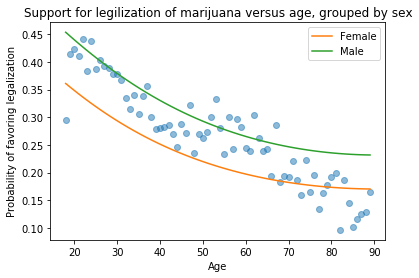

In [76]:
grouped = gss.groupby('age')
favor_by_age = grouped['grass'].mean()
plt.plot(favor_by_age, 'o', alpha=0.5)

plt.plot(df['age'], pred2, label='Female')
plt.plot(df['age'], pred1, label='Male')

plt.xlabel('Age')
plt.ylabel('Probability of favoring legalization')
plt.title('Support for legilization of marijuana versus age, grouped by sex')
plt.legend();

## Summary

At this point, I'd like to summarize the topics we've covered so far, and make some connections that might clarify the big picture.

A central theme of this course is "exploratory data analysis", which is a process and a set of techniques for working with data, especially in the early stages of a project, or when you are working with a new data set.

The last four notebooks demonstrate the steps of this process:

- Notebook 7 is about importing and cleaning the data, and checking for errors and other special conditions.  This might not be the most exciting part of the process, but if you skip these steps, it can come back to haunt you.  Time spent cleaning and validating data can save you from embarrassing, and sometimes expensive, errors.

- Notebook 8 is about exploring variables one at a time, visualizing distributions using PMFs, CDFs, and KDE, and choosing appropriate summary statistics.

- In Notebook 9 we explored relationships between variables two at a time, using scatter plots and other visualizations; and we quantified those relationships using correlation and simple regression.

- Finally, in Notebook 10, we explored multivariate relationships using multiple regression and logistic regression.

From Notebook 7, you might remember that we looked at the distribution of birth weights from the National Survey of Family Growth.

If you only remember one thing, remember the 99 pound babies, and how much it can mess up your results if you don't validate the data.

In Notebook 8 we looked at the distributions of age, income, and other variables from the General Social Survey.

I recommended using CDFs as the best way to explore distributions.

But when you present to audiences that are not familiar with CDFs, you can use PMFs if there are a small number of unique values, and KDE if there are a lot.

In Notebook 9 we looked at heights and weights from the BRFSS, and developed several ways to visualize relationships between variables, including scatter plots, violin plots, and box plots like this one.

We used the coefficient of correlation to quantify the strength of a relationship.  We also used simple regression to estimate slope, which is often what we care more about, not correlation.

But remember that both of these methods only capture linear relationships; if the relationship is non-linear, they can be misleading.  Always look at a visualization, like a scatter plot, before computing correlation or simple regression.

In Notebook 10 we used multiple regression to add control variables and to describe non-linear relationships.  And finally we used logistic regression to explain and predict binary variables.

We moved through a lot of material quickly, but if you practice and apply these methods to other questions and other dataset, you will learn more as you go.

Also, I am happy to report that you now have the prerequisites you need to appreciate [this xkcd cartoon](https://xkcd.com/2048/).

<img src="https://imgs.xkcd.com/comics/curve_fitting_2x.png" width="400">